# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

import xgboost as xgb

In [2]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

In [4]:
# Load write dataset
x_ds_t100 = pd.read_csv('datasets/exp90c_2h/col100/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_ds_t100.shape)
x_ds_t100.head(5)

(7803, 1864)


,timestamp,container_blkio_device_usage_total_0,container_blkio_device_usage_total_1,container_blkio_device_usage_total_2,container_blkio_device_usage_total_3,container_blkio_device_usage_total_4,container_blkio_device_usage_total_5,container_blkio_device_usage_total_6,container_blkio_device_usage_total_7,container_blkio_device_usage_total_8,...,network_transmit_bytes_per_container_35,network_transmit_bytes_per_container_36,network_transmit_bytes_per_container_37,network_transmit_bytes_per_container_38,network_transmit_bytes_per_container_39,network_transmit_bytes_per_container_40,network_transmit_bytes_per_container_41,network_transmit_bytes_per_container_42,network_transmit_bytes_per_container_43,network_transmit_bytes_per_container_44
0,1761764950,25874432,49966153728,25874432,48959823872,939503616,54006779904,939503616,49252225024,126316544,...,9830.733229,0,91585.415260,0,12174.886948,0,84544.341801,0,0.0,0.0
1,1761764951,25874432,49966264320,25874432,48959823872,939503616,54006779904,939503616,49252225024,126316544,...,12617.713285,0,97118.367347,0,12799.949354,0,97232.342007,0,0.0,0.0
2,1761764952,25874432,49966264320,25874432,48959823872,939503616,54006779904,939503616,49252225024,126316544,...,11999.762131,0,103181.455064,0,13015.958816,0,92537.726045,0,0.0,0.0
3,1761764953,25874432,49966264320,25874432,48959823872,939503616,54006779904,939503616,49252225024,126316544,...,13355.328158,0,80528.189911,0,13181.699687,0,86272.084806,0,0.0,0.0
4,1761764954,25874432,49966264320,25874432,48959823872,939503616,54006779904,939503616,49252225024,126316544,...,12512.404896,0,96229.002764,0,13205.837019,0,107943.632075,0,0.0,0.0


In [5]:
y_ds_t100 = pd.read_csv('datasets/exp90c_2h/col100/20251029_190910599_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_ds_t100.shape)
y_ds_t100.head(5)

(7803, 45)


,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
0,1761764950,0,0,0,0,0,0,0.000000,0.0,0.0,...,0,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0
1,1761764951,9,0,0,0,3,2,0.059494,0.0,0.0,...,3,5,3.777778,0.833333,4.0,4.333333,5.0,5.0,5.0,5
2,1761764952,16,0,0,0,5,1,0.105073,0.0,0.0,...,3,35,5.750000,7.827303,4.0,4.000000,30.5,35.0,35.0,35
3,1761764953,24,0,0,0,4,1,0.156581,0.0,0.0,...,2,35,5.000000,6.433607,4.0,4.000000,18.5,35.0,35.0,35
4,1761764954,31,0,0,0,4,1,0.207422,0.0,0.0,...,2,35,4.677419,5.670903,4.0,4.000000,8.0,35.0,35.0,35


# KDE for write dataset metrics

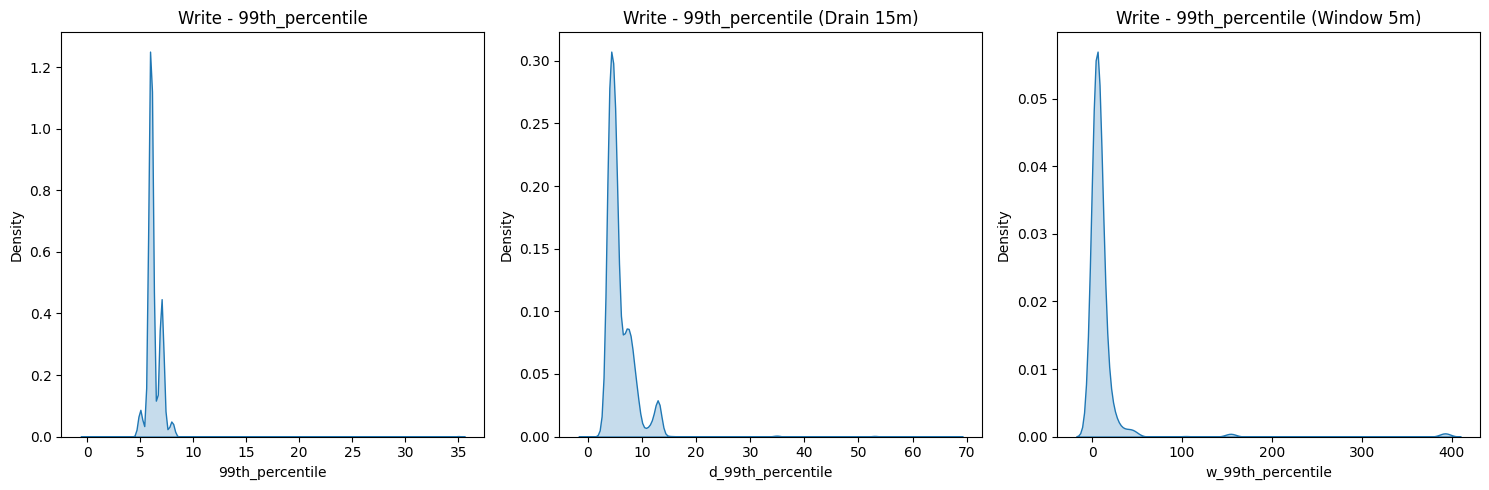

In [6]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(y_ds_t100['99th_percentile'],fill=True, ax=axes[0])
axes[0].set_title("Write - 99th_percentile")

sns.kdeplot(y_ds_t100['d_99th_percentile'],fill=True, ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")

sns.kdeplot(y_ds_t100['w_99th_percentile'],fill=True, ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [13]:
y_ds_t300_filtered = y_ds_t300.iloc[600:].copy()
y_ds_t300_filtered.head()

,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
600,1762823256,4502,0,0,0,5,1,6.000585,7.503824,6.485706,...,2,86,4.540000,7.880487,3.0,4.0,8.0,30.64,41.326667,86
601,1762823257,4509,0,0,0,5,1,6.001918,7.503824,6.485706,...,2,86,4.530000,7.885198,3.0,4.0,8.0,30.64,41.326667,86
602,1762823258,4516,0,0,0,5,1,6.004574,7.503824,6.485706,...,2,86,4.533333,7.884761,3.0,4.0,8.0,30.64,41.326667,86
603,1762823259,4524,0,0,0,5,1,6.005896,7.503824,6.485706,...,2,86,4.530000,7.885198,3.0,4.0,8.0,30.64,41.326667,86
604,1762823260,4531,0,0,0,5,1,6.008541,7.503824,6.485706,...,2,86,4.576667,8.005691,3.0,4.0,8.0,31.66,41.326667,86


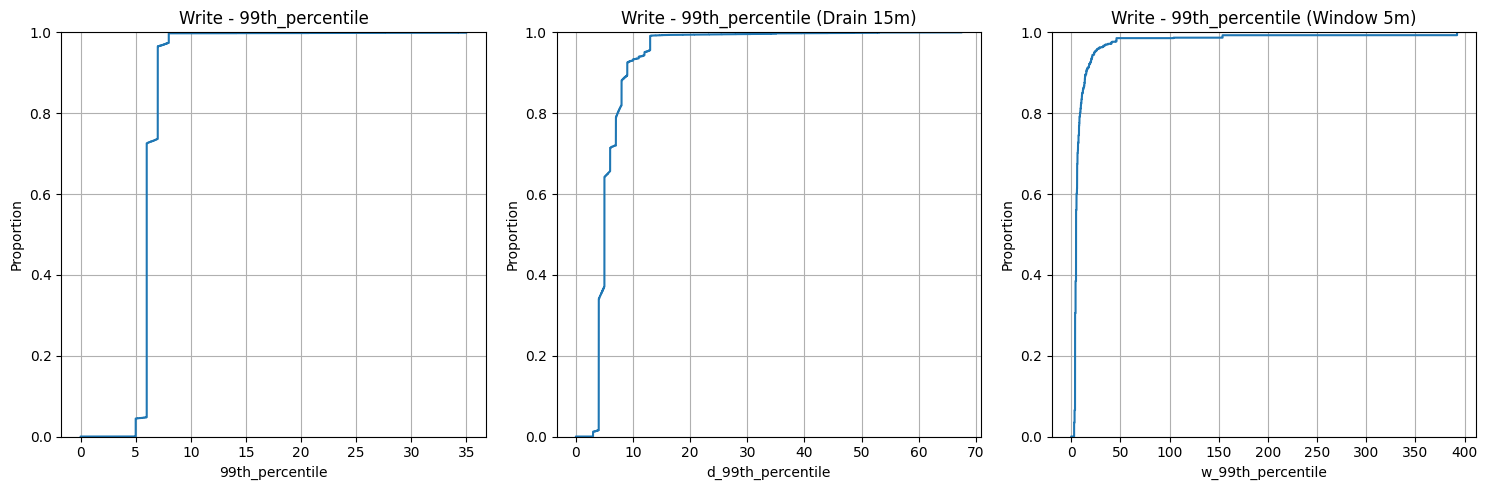

In [7]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.ecdfplot(data=y_ds_t100, x='99th_percentile', ax=axes[0])
axes[0].set_title("Write - 99th_percentile")
axes[0].grid(True)

sns.ecdfplot(data=y_ds_t100, x='d_99th_percentile', ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")
axes[1].grid(True)

sns.ecdfplot(data=y_ds_t100, x='w_99th_percentile', ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [8]:
y_ds_t100_filtered = y_ds_t100[
    (y_ds_t100['w_99th_percentile'] > 100.00)
]
y_ds_t100_filtered.head()

,timestamp,queries_num,queries_requested,errors_occurred,iter_errors_occurred,average_latency,99_9_latency_percentile,mean_rate,one_minute_rate,five_minute_rate,...,w_min,w_max,w_mean,w_std_dev,w_median,w_75th_percentile,w_95th_percentile,w_98th_percentile,w_99th_percentile,w_99_9th_percentile
2319,1761767269,17394,0,0,0,2,1,7.044173,7.495836,7.495826,...,1,846,10.826190,69.884328,2.0,3.0,4.00,53.84,392.333333,846
2320,1761767270,17401,0,0,0,2,1,7.044154,7.504164,7.497548,...,1,846,10.814286,69.885715,2.0,3.0,4.00,53.84,392.333333,846
2321,1761767271,17409,0,0,0,2,1,7.044542,7.504164,7.497548,...,1,846,10.819048,69.885352,2.0,3.0,4.65,53.84,392.333333,846
2322,1761767272,17416,0,0,0,2,1,7.044524,7.504164,7.497548,...,1,846,10.816667,69.885636,2.0,3.0,4.65,53.84,392.333333,846
2323,1761767273,17424,0,0,0,2,1,7.044910,7.504164,7.497548,...,1,846,10.816667,69.885636,2.0,3.0,4.65,53.84,392.333333,846


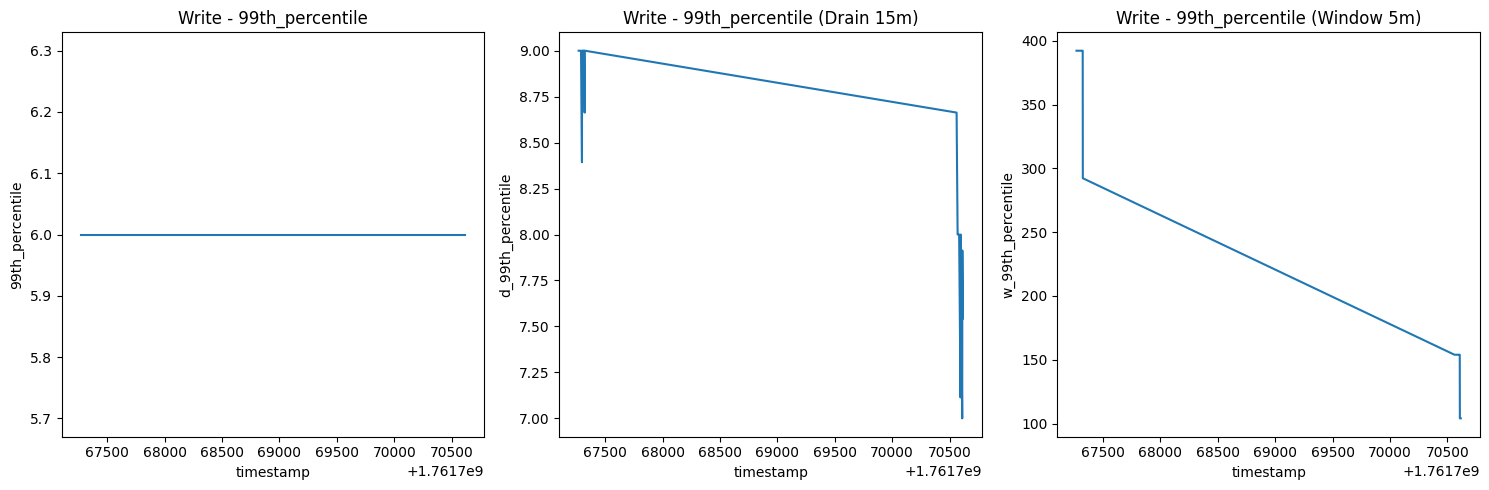

In [9]:
# 99th_percentile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(x="timestamp", y="99th_percentile", data=y_ds_t100_filtered, ax=axes[0])
axes[0].set_title("Write - 99th_percentile")
# axes[0].grid(True)

sns.lineplot(x="timestamp", y="d_99th_percentile", data=y_ds_t100_filtered, ax=axes[1])
axes[1].set_title("Write - 99th_percentile (Drain 15m)")
# axes[1].grid(True)

sns.lineplot(x="timestamp", y="w_99th_percentile", data=y_ds_t100_filtered, ax=axes[2])
axes[2].set_title("Write - 99th_percentile (Window 5m)")
# axes[2].set_xlim(0.0, 50)
# axes[2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [6]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

## T300

In [7]:
# Full dataset - wihout normalization...

random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
random_forest_model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = random_forest_model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 17.517528s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.34%
Rand. Forest Training time: 22.61572s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 3.22%
Rand. Forest Training time: 33.23173s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 16.67%


In [54]:
# Full dataset, using pipeline to normalize features and target.

# Define the feature pipeline
feature_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # Normalize input features
])

rf_regressor = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# Combine with target scaling using TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('preprocess', feature_pipeline),
        ('model', rf_regressor)
    ]),
    transformer=MinMaxScaler()  # Normalizes the target y
)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 30.79498s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.10%
Rand. Forest Training time: 52.514156s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.43%
Rand. Forest Training time: 73.947967s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 6.83%


In [55]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 25.202146s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.09%
Rand. Forest Training time: 59.407267s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 3.09%
Rand. Forest Training time: 69.290943s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 5.87%
